# Gastos diretos do Governo Federal 2011-2017

[Vídeo da Apresentação](https://youtu.be/YKQOTrRc6Ck)

&nbsp;

**Participantes:**

Bruno Maletta Monteiro

Francisco Galuppo Azevedo

Thais Soares Lamas

&nbsp;

___
# Índice

1. [Introdução](#introducao)
1. [Metodologia](#metodologia)
  1. [Sobre a base](#base)
  1. [Métodos e modelos](#modelos)
1. [Bibliotecas necessárias](#bibliotecas)
1. [Consultas](#consultas)
1. [Caracterização](#caracterizacao)   
  1. [Sumário dos dados](#sumario)
  1. [Gráfico em barras dos anos](#barra-anos)
  1. [Gráfico em barras dos meses](#barra-meses)
  1. [Gráfico em barras empilhadas dos meses](#barra-empilhadas)
  1. [Gráfico em barras do número de ministérios](#barra-ministerios)
  1. [Tempo de existência dos ministérios](#tempo-ministerios)
  1. [Histograma dos gastos mensais](#histograma-mes)
  1. [Tree Map dos gastos totais](#tree-map)
1. [Testes de Hipótese](#testes)
  1. [Gastos sazonais?](#sazon)
  1. [Gastos políticos?](#politicos)
1. [Classificação dos dados](#classificacao)
  1. [KNN](#knn)
  1. [Regressão Logística](#logis)
1. [Regressão nos dados](#regressao)
  1. [Regressão KNN](#regressao_knn)
  1. [Regressão linear regularizada](#regul)
1. [Conclusões](#conclusoes)

<a id="introducao"></a>
&nbsp;

___
# Introdução

O nosso trabalho parte da ideia de estudar os gastos diretos do governo federal, isto é, as obras e serviços que o governo contrata, não engloba os gastos com pessoal. Gostaríamos de saber como esses gastos são divididos, como eles variaram com o tempo, o que eles dizem sobre os ministérios etc.

Assim, buscamos os dados disponibilizados pelos governos passados através do portal da transparência. O projeto [brasil.io](https://brasil.io/dataset/gastos-diretos/gastos) busca facilitar o acesso da população aos dados públicos, que muitas vezes estão dispersos ou em formatos não convencionais, e portanto foi nossa escolha de fonte. Eles também disponibilizam um script de raspagem e consulta dos dados diretamente do portal da transparência.

Com os dados em mãos, escolhemos algumas perguntas de interesse pra estudar:

1. Primeiramente, como são distribuídos os gastos ao longo do ano? São uniformemente distribuídos ou há meses de maior gasto?
2. E quanto aos anos eleitorais, os gastos aumentam ou são comparáveis com os demais?
3. Conseguimos classificar os ministérios apenas pela quantia e data dos gastos?
4. Quais são as tendências desses gastos? De alta? De baixa?

<a id="metodologia"></a>
&nbsp;

___
# Metodologia

Nesta seção, falaremos um pouco sobre a base de dados que escolhemos para abordar o problema e os métodos preferidos para tal.

<a id="base"></a>
&nbsp;

### Sobre a base

Bom, a nossa base trata sobre os pagamentos para aquisição e contratação de obras e compras governamentais, dentre outros, realizados pelos órgãos e entidades da Administração Pública Federal, que executam as despesas pelo Sistema Integrado de Administração Financeira do Governo Federal (Siafi). A seguir temos os metadados da base:

 	 	 	
|Coluna                 |Tipo                                     |Título                            |
|-----------------------|-----------------------------------------|----------------------------------|
|ano 	                |integer 	                              |Ano 	                             |
|mes 	                |integer 	                              |Mês 	                             |
|data_pagamento 	    |date 	                                  |Data do Pagamento 	             |
|nome_orgao 	        |string (max_length=45)                   |Órgão 	                         |
|nome_acao 	            |string (max_length=247)                  |Ação 	                         |
|numero_documento 	    |string (max_length=112)                  |Número do Documento 	             |
|codigo_favorecido 	    |string (max_length=112)                  |Documento do Favorecido 	         |
|nome_favorecido 	    |string (max_length=208)                  |Nome do Favorecido 	             |
|valor 	                |decimal (max_digits=18, decimal_places=2)|Valor 	                         |
|codigo_acao 	        |string (max_length=4) 	                  |Código da Ação 	                 |
|codigo_elemento_despesa|integer 	                              |Código do Elemento da Despesa 	 |
|codigo_funcao 	        |integer 	                              |Código da Função 	             |
|codigo_grupo_despesa 	|integer 	                              |Código do Grupo da Despesa 	     |
|codigo_orgao 	        |integer 	                              |Código do Órgão 	                 |
|codigo_orgao_superior 	|integer 	                              |Código do Órgão Superior 	     |
|codigo_programa 	    |integer 	                              |Código do Programa                |
|codigo_subfuncao 	    |integer 	                              |Código da Subfunção               |
|codigo_unidade_gestora |integer 	                              |Código da Unidade Gestora         | 
|data_pagamento_original|string (max_length=112) 	              |Data do Pagamento (valor original)|
|gestao_pagamento 	    |string (max_length=112) 	              |Gestão do Pagamento               |
|linguagem_cidada 	    |string (max_length=199) 	              |Linguagem Cidadã 	             |
|nome_elemento_despesa 	|string (max_length=113) 	              |Elemento da Despesa 	             |
|nome_funcao 	string  |(max_length=21) 	                      |Função 	                         |
|nome_grupo_despesa 	|string (max_length=25) 	              |Grupo da Despesa 	             |
|nome_orgao_superior 	|string (max_length=45) 	              |Órgão Superior 	                 |
|nome_programa 	        |string (max_length=110) 	              |Programa 	                     |
|nome_subfuncao 	    |string (max_length=50) 	              |Subfunção 	                     |
|nome_unidade_gestora 	|string (max_length=45) 	              |Unidade Gestora                   |

O nosso banco trabalha com dados de janeiro de 2011 a dezembro de 2017, o que totalizam 50 gbs de informação. Fazer consultas sobre esse banco se tornou inviável e focamos apenas nas informações essenciais. Trabalharemos com os gastos mensais de cada órgão superior (ao longo do trabalho chamaremos de ministérios, mas também há a Presidência da República e o Gabinete da Vice-Presidência da República). A consulta de SQL em [Consultas](#consultas) faz exatamente isso.

<a id="modelos"></a>
&nbsp;

### Métodos e modelos

Neste trabalho, faremos uso de testes de hipótese por simulação e por teste de permutação; classificadores KNN e regressão logística regularizada; e regressores KNN e linear.

<a id="bibliotecas"></a>
&nbsp;

___
# Bibliotecas necessárias

Abaixo temos as bibliotecas necessárias para o trabalho

A biblioteca abaixo é para fazer tree maps. Deixamos a célula para instalar caso não tenha.

In [ ]:
! pip install --user squarify

E nesta célula temos as demais bibliotecas, que são mais comuns e já devem estar disponíveis.

In [56]:
# Apenas para consultar no banco, não foi mais necessário
import sqlite3

# Bibliotecas para manipular os dados
import pandas as pd
import numpy as np

# Gráficos
from matplotlib import rc
import matplotlib.pyplot as plt
import squarify

# Para algumas medidas 
from scipy.stats import norm  
from scipy.stats import kstest
from scipy.stats import percentileofscore
from scipy.stats import combine_pvalues

# Validação, treino, teste
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Classificação
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

# Regressão
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge # Linear least squares with l2 regularization.

<a id="consultas"></a>
&nbsp;

___
# Consultas

Cria conexão com o banco de dados. (NÃO RODAR SE NÃO TIVER O BANCO BAIXADO)

In [ ]:
conn = sqlite3.connect("/data/gastos_diretos/portal-transparencia.sqlite")
cursor = conn.cursor()

Consulta o banco de dados a fim de coletar os gastos mensais de todos os ministérios no período estudado. Salva em um arquivo csv para facilitar o trabalho e evitar muitas consultas (o banco é bem grande).

In [ ]:
cmd = """
select nome_orgao_superior, mes, ano, sum(valor) as gasto_total_mensal
    from gastos_diretos
    group by nome_orgao_superior, ano, mes
    order by nome_orgao_superior, ano, mes
"""

Ministerios_mes_ano = pd.read_sql_query(cmd, conn)
Ministerios_mes_ano.to_csv("Ministerios_mes_ano.csv", index=False)

<a id="caracterizacao"></a>
&nbsp;

___
# Caracterização

Nesta seção, mostraremos algumas informações e gráficos que conseguimos extrair dos dados.

Leitura dos dados:

In [ ]:
dados = pd.read_csv("Ministerios_mes_ano.csv")

<a id="sumario"></a>
&nbsp;

### - Sumário dos dados

Podemos extrair algumas informações básicas sobre os gastos.

In [3]:
dados["gasto_total_mensal"].describe().to_frame()

,gasto_total_mensal
count,2.094000e+03
mean,7.916545e+08
std,1.729442e+09
min,1.172500e+02
25%,4.138763e+07
50%,1.838175e+08
75%,8.433709e+08
max,4.068384e+10


Vemos que os dados entre o primeiro e o terceiro quartil estão razovelmente próximos, enquanto que o valor mínimo e o máximo aparecem como discrepantes, outliers. Quem fez o gasto mínimo? E o máximo?

In [4]:
print("Gasto mínimo:", dados[dados["gasto_total_mensal"] == dados["gasto_total_mensal"].min()]["nome_orgao_superior"].values[0])
print("Gasto máximo:", dados[dados["gasto_total_mensal"] == dados["gasto_total_mensal"].max()]["nome_orgao_superior"].values[0])

Gasto mínimo: MINISTERIO DO TRABALHO E EMPREGO
Gasto máximo: MINISTERIO DA FAZENDA


<a id="barra-anos"></a>
&nbsp;

### - Gráfico em barras dos anos

Podemos estudar como foi o crescimento anual dos gastos totais dos ministérios

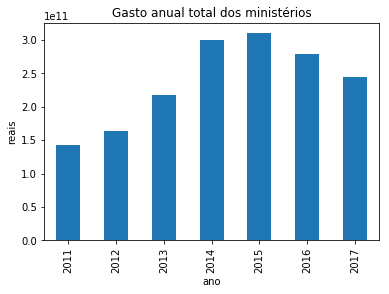

In [5]:
dados.groupby("ano")["gasto_total_mensal"].sum().plot.bar()
plt.title("Gasto anual total dos ministérios")
plt.ylabel("reais")
plt.show()

Vemos que os gastos mais do que dobraram entre 2011 e 2015. Podemos ver também a variação entre os anos:

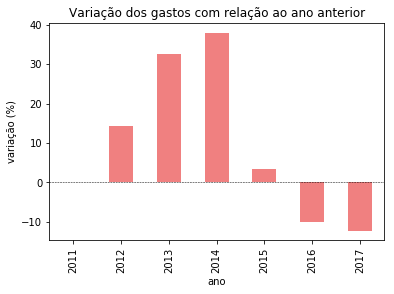

In [6]:
(dados.groupby("ano")["gasto_total_mensal"].sum().pct_change() * 100).plot.bar(color='lightcoral')
plt.axhline(y=0, linewidth=0.5, color="k", ls="--")

plt.title("Variação dos gastos com relação ao ano anterior")
plt.ylabel("variação (%)")
plt.show()

Vemos que a variação foi positiva e crescente de 2012 e 2014. O ano de 2015 parece mostrar uma desaceleração, enquanto que 2016 e 2017 já estão em uma fase de queda dos gastos diretos.

<a id="barra-meses"></a>
&nbsp;

### - Gráfico em barras dos meses

A seguir, o gráfico dos gastos mensais com alguns detalhes históricos (são apenas para contextualização histórica, não assumem qualquer tipo de correlação)

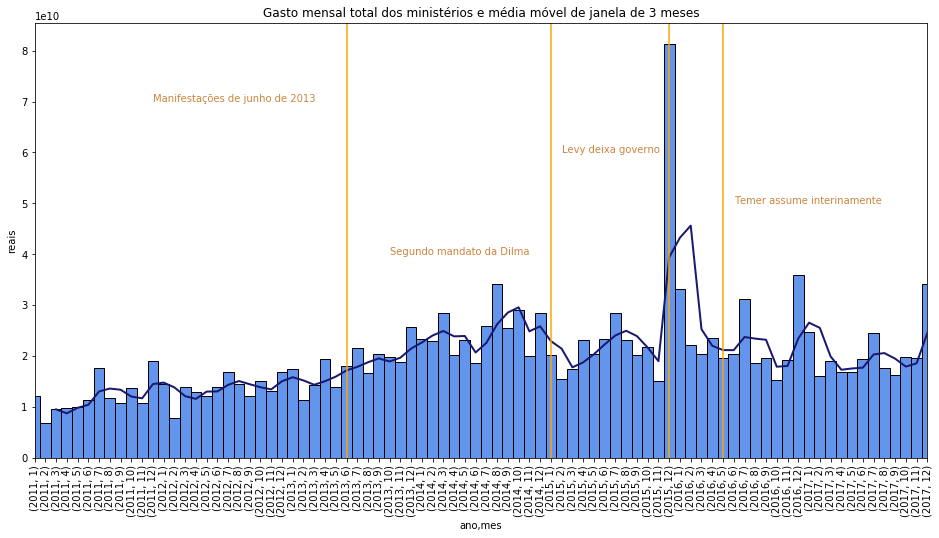

In [7]:
fig, ax = plt.subplots(figsize=(16,8))

# Bar plot e média móvel
temp = dados.groupby(["ano", "mes"])["gasto_total_mensal"].sum()
temp.plot.bar(width=1, xticks=[], color="cornflowerblue", edgecolor="k")
temp.rolling(window=3).mean().plot(color="midnightblue", linewidth=2)

# Linhas e textos
plt.axvline(x=29, color="orange")
plt.text(11, 7*1e10, "Manifestações de junho de 2013", color="peru")

plt.axvline(x=48, color="orange")
plt.text(33, 4*1e10, "Segundo mandato da Dilma", color="peru")

plt.axvline(x=59, color="orange")
plt.text(49, 6*1e10, "Levy deixa governo", color="peru")

plt.axvline(x=64, color="orange")
plt.text(65, 5*1e10, "Temer assume interinamente", color="peru")

# detalhes
ax.tick_params(axis='x', rotation=90)
plt.title("Gasto mensal total dos ministérios e média móvel de janela de 3 meses")
plt.ylabel("reais")
plt.show()

Os gastos parecem crescer desde o início, assumindo um ritmo um pouco mais acelerado a partir de 2013. Uma idéia seria analisar os dados de crescimento populacional e da inflação para melhor contextualizar, pois não sabemos quais motivos levaram ao aumento. Entre a metade de 2014 e o final de 2015, os gastos parecem oscilar, e em dezembro de 2015 temos um grande pico de gastos diretos. Após o pico, os gastos parecem oscilar, se mantendo quando Michel Temer assume a Presidência da República, mas sem muita tendência de aumento ou de queda.

<a id="barra-empilhadas"></a>
&nbsp;

### - Gráfico em barras empilhadas

Continuando o gráfico anterior, podemos dividir os gastos entre os ministérios e ver como é a variação.


Combinando as colunas de mes e ano em uma coluna de datas.

In [8]:
novo = dados.copy()

novo['ano'] = novo['ano'].astype('str')
novo['mes'] = novo['mes'].astype('str')

novo['data'] = dados[["ano", "mes"]].apply(lambda x: "-".join(x.map(str)), axis=1)
novo = novo[["nome_orgao_superior", "gasto_total_mensal", "data"]]

Coloca zeros nos meses que determinado ministerio não gastou ou não existia. Isso vai facilitar na hora de criar determinados gráficos.

In [9]:
datas = list(novo['data'].drop_duplicates())
ministerios = novo['nome_orgao_superior'].drop_duplicates()

for mini in ministerios:
    existentes = set(novo[novo["nome_orgao_superior"] == mini]["data"])
    zeros = [x for x in datas if x not in existentes]
    for i in range(len(zeros)):
        novo.loc[str(novo.shape[0]+1)] = [mini, 0.0, zeros[i]]

Como estamos trabalhando com muitos ministérios, é importante definir uma cor para cada um (RODAR ATÉ SAIR UMA BOA PALETA DE CORES):

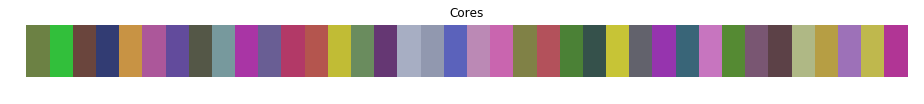

In [21]:
# Cria um vetor de cores aleatórias, então as vezes demora até sair uma boa paleta
r = lambda: np.random.randint(50,206)
colors = ['#'+''.join('%02x'%i for i in [r(),r(),r()]) for i in range(len(ministerios))]

# Mostra a paleta
fig, ax = plt.subplots(figsize=(16,1))
plt.title("Cores")
pd.Series([1 for _ in ministerios]).plot.bar(color=colors, width=1)
plt.axis('off')
plt.show()

Cria um gráfico com o gasto mensal dos ministérios ao longo do tempo. Cada cor representa um ministério.

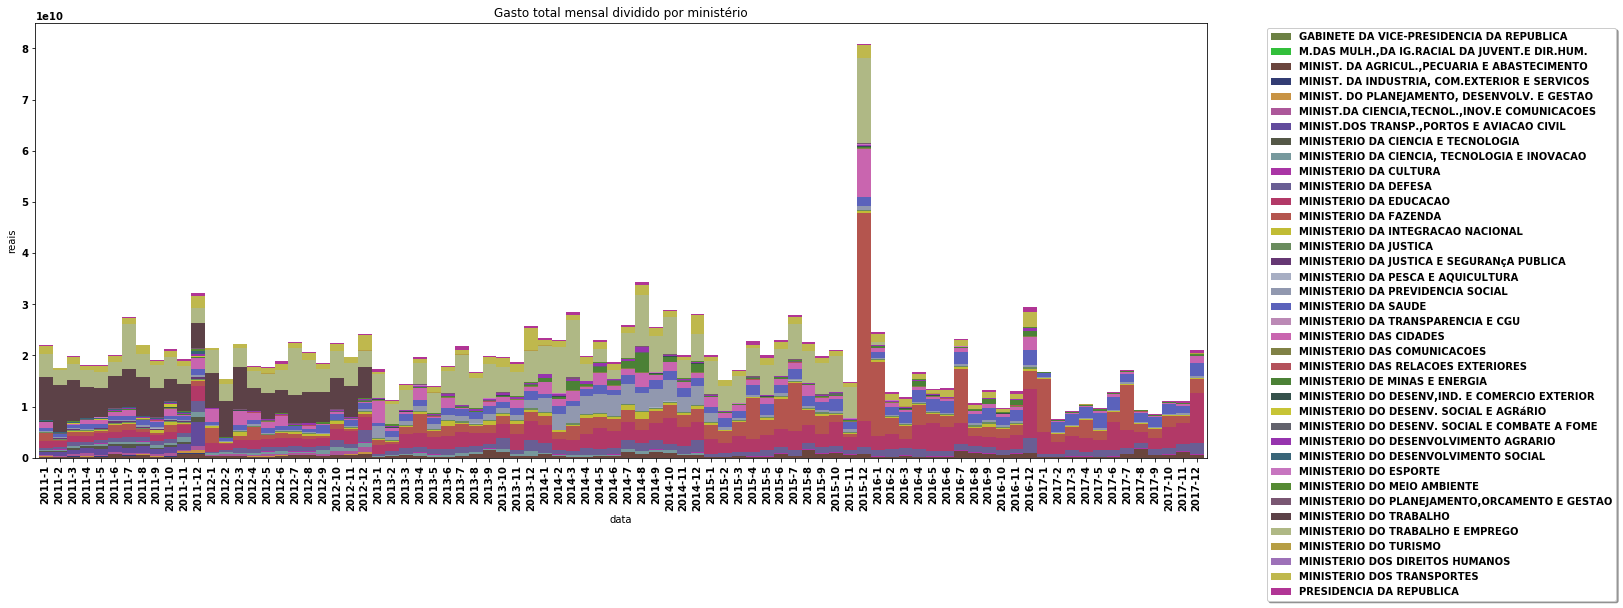

In [22]:
rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(21,8)) 

# Cria o gráfico empilhando os gastos dos ministérios
margin_bottom = np.zeros(len(datas))
for num, mini in enumerate(ministerios):
    values = list(novo[novo['nome_orgao_superior'] == mini].loc[:, 'gasto_total_mensal'])
    novo[novo['nome_orgao_superior'] == mini].plot.bar(x='data',y='gasto_total_mensal',
        ax=ax, stacked=True, color=colors[num], bottom=margin_bottom, label=mini, width=1)
    margin_bottom += values

# Termina plot    
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1), shadow=True, ncol=1)
#plt.savefig("Historico.pdf", bbox_inches='tight')
plt.title("Gasto total mensal dividido por ministério")
plt.ylabel("reais")
plt.show()

Vemos que aos poucos o Ministério da Fazenda aumenta seus gastos diretos e, em partes, é responsável pelo grande pico que comentamos anteriormente. Notável também é a variação do Ministério do Trabalho, com grande participação até 2012, mas diminui os gastos e acaba mudando de nome.

<a id="barra-ministerios"></a>
&nbsp;

### - Gráfico em barras do número de ministérios

Abaixo temos um gráfico de barras com o número de ministérios por ano, ao longo do período, que fizeram algum gasto direto.

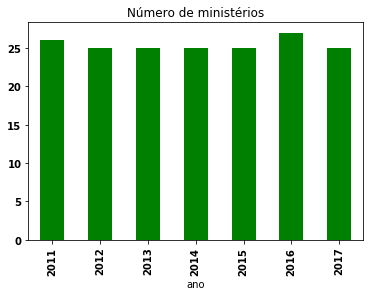

In [23]:
dados.groupby(["ano", "nome_orgao_superior"]).size().groupby("ano").size().plot.bar(color="green")
plt.title("Número de ministérios")
plt.show()

Vemos que o número de ministérios com gastos diretos pouco alterou ao longo do tempo. Com o gráfico de barras empilhadas, sabemos que tivemos mais ministérios do que o máximo do gráfico acima mostra. Logo, não podem ser os mesmos ministérios em todos os anos. Portanto, estudemos a distribuição do tempo de existência dos ministérios.

<a id="tempo-ministerios"></a>
&nbsp;

### - Tempo de existência dos ministérios

Estudemos o tempo para cada ministério:

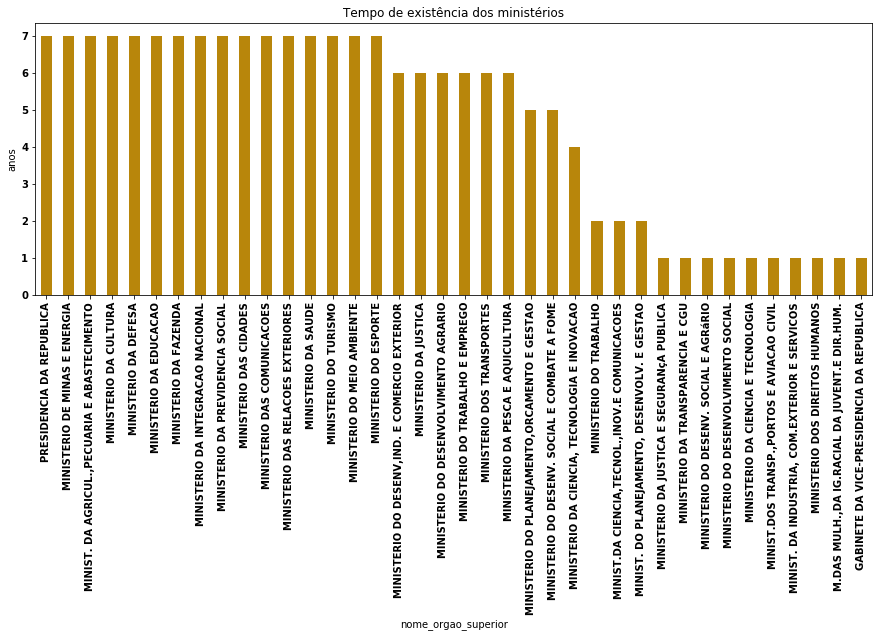

In [24]:
fig, ax = plt.subplots(figsize=(15,5)) 
mini_hist = dados.groupby(["nome_orgao_superior", "ano"]).size().groupby("nome_orgao_superior").size().sort_values(ascending=False)
mini_hist.plot.bar(color="darkgoldenrod")
plt.title("Tempo de existência dos ministérios")
plt.ylabel("anos")
plt.show()

E sua distribuição:

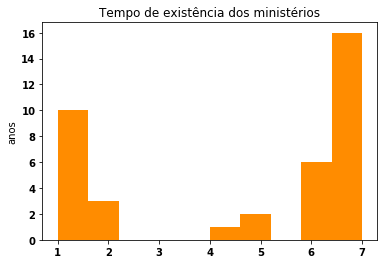

In [25]:
mini_hist.plot.hist(color="darkorange")
plt.title("Tempo de existência dos ministérios")
plt.ylabel("anos")
plt.show()

Grande parte dos ministérios (16 deles) permaneceu por todo período. Os que existiram por pouco tempo (pouco tempo dentro desse intervalo), um ou dois anos, formam uma outra grande fração (13 ministérios). Os demais se encontram entre esses grupos.

<a id="histograma-mes"></a>
&nbsp;

### - Histograma dos gastos mensais

Podemos querer estudar a distribuição desses gastos mensais totais. 

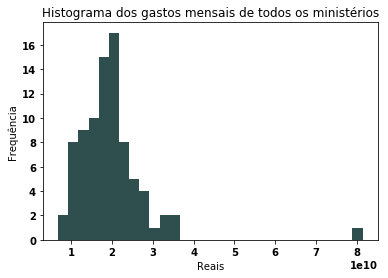

In [26]:
dados.groupby(["ano", "mes"])["gasto_total_mensal"].sum().plot.hist(bins=30, color="darkslategrey")
plt.title("Histograma dos gastos mensais de todos os ministérios")
plt.xlabel("Reais")
plt.ylabel("Frequência")
plt.show()

Vemos que temos uma região concentrada entre 10 e 40 bilhões de reais, e o que parece ser um caso isolado na faixa de 80 bilhões. Vamos estudar a região mais concentrada:

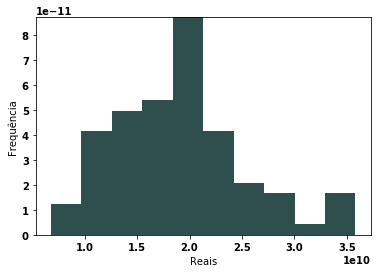

In [27]:
gasto_mensal = dados.groupby(["ano", "mes"])["gasto_total_mensal"].sum()
gasto_mensal = gasto_mensal[gasto_mensal < 5*1e10]
gasto_mensal.plot.hist(bins=10, density=True, color="darkslategrey")
plt.xlabel("Reais")
plt.ylabel("Frequência")
plt.show()

A distribuição parece vir de uma soma de diversos modelos, mas podemos ver quão bem a normal se ajusta. 

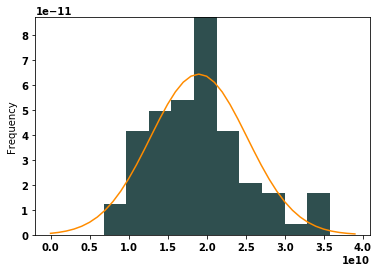

In [28]:
gasto_mensal.plot(kind='hist', density=True, color="darkslategrey")

lim = np.arange(0, 4*1e10, 1e9)
plt.plot(lim, norm.pdf(lim, gasto_mensal.mean(), gasto_mensal.std(ddof=1)), color="darkorange")
plt.show()

O teste de Kolmogorov-Smirnov pode nos ser útil.

In [29]:
print("p-valor:", kstest(gasto_mensal, 'norm', (gasto_mensal.mean(), gasto_mensal.std(ddof=1)))[1])

p-valor: 0.14357484286698807


Com um p-valor de 0.14, não podemos descartar que os gastos (com exceção da anomalia) são instâncias de uma normal.

<a id="tree-map"></a>
&nbsp;

### - Tree map

Uma forma de visualizar os gastos totais no período é o TREE MAP. Façamos um.

Primeiramente, uma pequena função que escolhe alguns ministérios para aparecer no plot do tree map.

In [30]:
def tree_map_string(x):
    val = round(x[1]*100/total,2)
    if val > 4: 
        return str(x[0])+"\n ({}%)".format(round(x[1]*100/total,2))
    else:
        return ""

E com o código abaixo podemos criar um tree map dos gastos totais

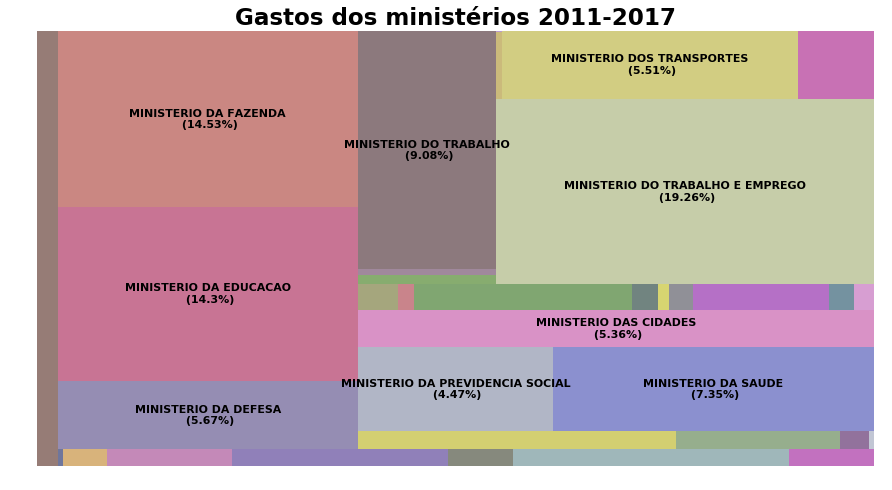

In [31]:
plt.rc('font', size=11)
fig = plt.gcf()
fig.set_size_inches(15, 8)

gasto_total = dados.groupby("nome_orgao_superior")["gasto_total_mensal"].sum().to_frame().reset_index()
gasto_total.columns = ["ministerio", "gasto_total"]
total = gasto_total["gasto_total"].sum()
labs = gasto_total.apply(tree_map_string, axis=1)

squarify.plot(sizes=gasto_total["gasto_total"], label=labs, color=colors, alpha=0.7)
plt.title("Gastos dos ministérios 2011-2017",fontsize=23,fontweight="bold")

plt.axis('off')
plt.show()

Podemos ver os demais ministérios na seguinte tabela:

In [32]:
porcentagem = gasto_total.copy()
porcentagem["%"] = gasto_total.apply(lambda x: "{}%".format(round(x[1]*100/total,2)), axis=1)
porcentagem.sort_values(by=['gasto_total'], ascending=False)

,ministerio,gasto_total,%
33,MINISTERIO DO TRABALHO E EMPREGO,3.193435e+11,19.26%
12,MINISTERIO DA FAZENDA,2.408337e+11,14.53%
11,MINISTERIO DA EDUCACAO,2.370989e+11,14.3%
32,MINISTERIO DO TRABALHO,1.504788e+11,9.08%
18,MINISTERIO DA SAUDE,1.218837e+11,7.35%
10,MINISTERIO DA DEFESA,9.401642e+10,5.67%
36,MINISTERIO DOS TRANSPORTES,9.130610e+10,5.51%
20,MINISTERIO DAS CIDADES,8.878980e+10,5.36%
17,MINISTERIO DA PREVIDENCIA SOCIAL,7.403123e+10,4.47%
2,"MINIST. DA AGRICUL.,PECUARIA E ABASTECIMENTO",4.092354e+10,2.47%


<a id="testes"></a>
&nbsp;

___
# Testes de Hipótese

Depois dessa análise sobre os dados, partimos para as nossas perguntas. Nesta seção, investigaremos as duas primeiras, se os gastos são uniformes ao longo do ano e se existe alguma anomalia nos anos eleitorais.

<a id="sazon"></a>
&nbsp;

### - Gastos sazonais?

Podemos testar se os gastos ao longo do ano são uniformemente distribuídos ou se em determinadas épocas há mais gastos. Por exemplo, considere os gastos totais mensais no ano de 2011:

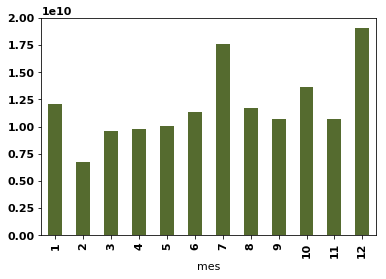

In [33]:
dados[dados["ano"] == 2011].groupby("mes")["gasto_total_mensal"].sum().plot.bar(color="darkolivegreen")
plt.show()

Vemos que os gastos em julho foram quase três vezes maiores do que os gastos em fevereiro. Essa diferença seria por razões administrativas ou por puro acaso? Vamos testar! Podemos usar a medida de **Total Variance Distance** (TVD) para um teste de hipótese sobre se os gastos são uniformes, simulando amostras de uma distribuição uniforme.

Continuemos trabalhando com os dados de 2011:

In [34]:
dados_2011 = dados[dados["ano"] == 2011].groupby("mes")["gasto_total_mensal"].sum().values

idx = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
hp1 = pd.DataFrame(index=idx)
hp1["2011"] = dados_2011 / dados_2011.sum()
hp1["unif"] = [1/12 for _ in range(12)]
hp1

,2011,unif
jan,0.084614,0.083333
fev,0.047455,0.083333
mar,0.066991,0.083333
abr,0.068177,0.083333
mai,0.070158,0.083333
jun,0.079615,0.083333
jul,0.123269,0.083333
ago,0.081969,0.083333
set,0.074630,0.083333
out,0.095180,0.083333


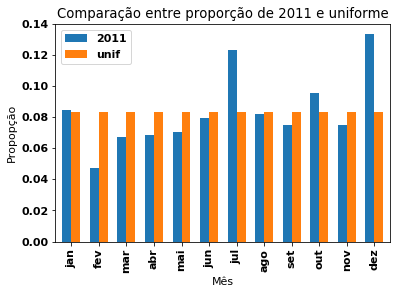

In [35]:
hp1.plot.bar(width=0.65)
plt.title("Comparação entre proporção de 2011 e uniforme")
plt.xlabel('Mês')
plt.ylabel('Propopção')
plt.show()

A função calcula o TVD entre duas distribuições:

In [36]:
def total_variation(p, q):
    return np.sum(np.abs(p - q)) / 2

E o valor seria o seguinte:

In [37]:
tvd = total_variation(hp1["2011"], hp1["unif"])
print("TVD entre gastos de 2011 e uniforme:", tvd)

TVD entre gastos de 2011 e uniforme: 0.10278051887552289


Considere a função abaixo que amostra proporções de uma população:

In [38]:
def sample_proportion(size, prop, n=10000):    
    grupo = size * prop
    resultados = np.zeros(n)
    
    for i in range(n):
        sample = np.random.randint(0, size, 100)
        resultados[i] = np.sum(sample < grupo) / 100
    
    return resultados

Em seguida, fazemos amostras da distribuição uniforme para cada mês de forma independente e depois dividimos pelo total a fim de que seja uma proporção.

In [39]:
# Parâmetros
size = 1000
numero_amostras = 10000
amostras = np.zeros(shape=(numero_amostras, len(hp1.index)))

# Amostra cada mês
for i, g in enumerate(hp1.index):
    p = hp1.loc[g]['unif']
    amostras[:, i] = sample_proportion(size, p, numero_amostras)

# Divide pelo total
for i in range(numero_amostras):
    amostras[i] /= amostras[i].sum()

O código abaixo calcula as distâncias para todas as amostras feitas

In [40]:
distancias = []
for i in range(numero_amostras):
    distancias.append(total_variation(hp1['unif'], amostras[i]))

E podemos visualizar como o TVD calculado aparece com relação às amostras:

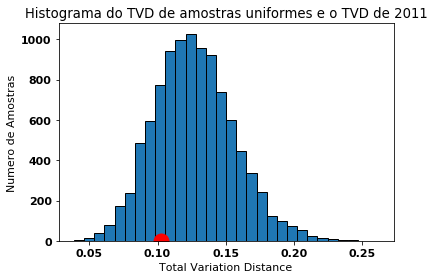

In [41]:
plt.hist(distancias, bins=30, edgecolor='k')
plt.plot([tvd], [0], 'ro', ms=15)

plt.title("Histograma do TVD de amostras uniformes e o TVD de 2011")
plt.ylabel('Numero de Amostras')
plt.xlabel('Total Variation Distance')
plt.show()

In [42]:
pvalor = 1 - percentileofscore(distancias, tvd) / 100
print("O p-valor da distribuição de 2011:", pvalor)

O p-valor da distribuição de 2011: 0.791


Com um p-valor tão elevado, não conseguimos descartar que os gastos sejam de fato uniformes. Façamos o mesmo cálculo para todos os anos:

In [43]:
unif = [1/12 for i in range(12)]
size = 1000
numero_amostras = 10000
pvalores = list()

for i in range(2011, 2018):
    dados_ano = dados[dados["ano"] == i].groupby("mes")["gasto_total_mensal"].sum().values
    hp1_ano = dados_ano / dados_ano.sum()
    tvd = total_variation(hp1_ano, unif)
    
    amostras = np.zeros(shape=(numero_amostras, len(unif)))

    # Amostra cada mês
    for i, g in enumerate(unif):
        amostras[:, i] = sample_proportion(size, g, numero_amostras)

    # Divide pelo total
    for i in range(numero_amostras):
        amostras[i] /= amostras[i].sum()

    # Calcula as distâncias
    distancias = []
    for i in range(numero_amostras):
        distancias.append(total_variation(unif, amostras[i]))
        
    # Salva o p-valor
    pvalores.append(1 - percentileofscore(distancias, tvd) / 100)
    
pvals = pd.DataFrame()
pvals["ano"] = [i for i in range(2011, 2018)]
pvals["pval"] = pvalores

pvals

,ano,pval
0,2011,0.7803
1,2012,0.9963
2,2013,0.9609
3,2014,0.9800
4,2015,0.0250
5,2016,0.6974
6,2017,0.8976


Apenas no ano de 2015 tivemos um p-valor menor do que 5%. Foi o ano do pico, vejamos como foram os gastos:

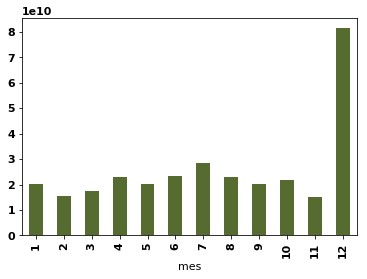

In [44]:
dados[dados["ano"] == 2015].groupby("mes")["gasto_total_mensal"].sum().plot.bar(color="darkolivegreen")
plt.show()

Realmente, o ano de 2015 não parece ser muito uniformemente distribuído...

Para finalizar esse teste, podemos pensar que os gastos de cada ano são independentes dos gastos dos demais anos (o que talvez não seja verdade). Se for o caso, podemos combinar os p-valores:

In [45]:
print("P-valor combinado (método de Fisher):", combine_pvalues(pvalores, "fisher")[1])

P-valor combinado (método de Fisher): 0.8349791396543083


Bom, com exceção talvez do ano de 2015, não podemos de fato descartar que os gastos diretos sejam uniformemente distribuídos ao longo do ano. Assim, concluímos nossa primeira pergunta sobre os dados.

<a id="politicos"></a>
&nbsp;

### - Gastos políticos?

Uma pergunta interessante de se testar é se em anos eleitorais (2012, 2014, 2016) os gastos são diferentes dos anos que não são (2011, 2013, 2015, 2017). Em particular, os gastos de maior interesse no assunto tocam à Presidência da República, órgão que administra a Secretaria Especial de Comunicação Social, órgão este responsável pela liberação de verbas e gerenciamento de contratos publicitários firmados pelo Governo Federal.

Primeiramente, vejamos como foram os gastos da Presidência da República no período.

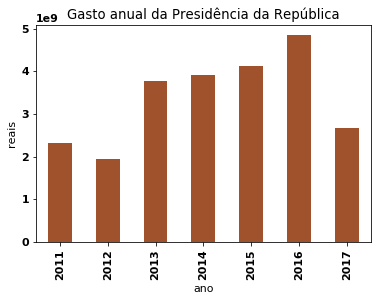

In [46]:
hp2 = dados[dados['nome_orgao_superior'] == "PRESIDENCIA DA REPUBLICA"].groupby("ano")["gasto_total_mensal"].sum()
hp2.plot.bar(color="sienna")
plt.title("Gasto anual da Presidência da República")
plt.ylabel("reais")
plt.show()

Os resultados não são muito animadores para nossa investigação, dado que os gastos dimuiram em 2012 e não aumentaram muito em 2014 e em 2016. Mas vejamos de forma mais aprofundada.

Mais cedo, investigamos o histórico dos gastos totais de todo o governo federal. Gostaríamos de comparar o gastos acima com os gastos totais. Para isso, seja $P_t$ e $G_t$ o gasto da Presidência da República e o gasto total de todo o governo federal no ano $t$, respectivamente. Queremos saber como $P_t$ variou em relação ao tanto que $G_t$ variou, isto é, queremos

$$V_{t+1} = \frac{\frac{P_{t+1}}{P_t}}{\frac{G_{t+1}}{G_t}}.$$

Vejamos essa variação:

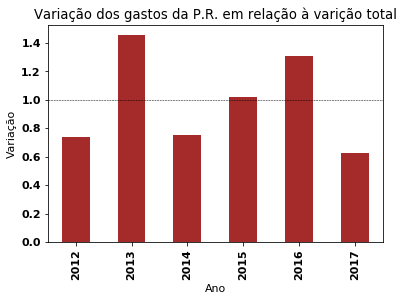

In [47]:
P = hp2.values
G = dados.groupby("ano")["gasto_total_mensal"].sum().values

V = []
for i in range(len(P)-1):
    V.append((P[i+1]/P[i]) / (G[i+1]/G[i]))
    
pd.DataFrame(V, index=[2012, 2013, 2014, 2015, 2016, 2017]).plot.bar(legend=None, color="brown")
plt.axhline(y=1, linewidth=0.5, color="k", ls="--")
plt.xlabel("Ano")
plt.ylabel("Variação")
plt.title("Variação dos gastos da P.R. em relação à varição total")
plt.show()

Vemos que os gastos da Presidência da República de 2012 e 2014 cresceram menos do que os demais gastos do governo (na verdade, como vimos, em 2012 eles diminuiram). Dos anos de interesse, apenas em 2016 a variação foi maior do que o esperado. Novamente, os resultados não são muito animadores.

Apenas como uma pequena digressão, podemos estudar se o crescimento dos gastos em 2013 tem alguma relação com as manifestações de junho desse ano:

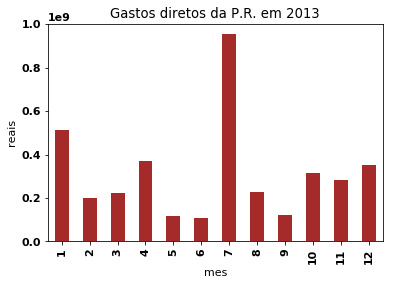

In [48]:
PR_2013 = dados[(dados['nome_orgao_superior'] == "PRESIDENCIA DA REPUBLICA") & (dados['ano'] == 2013)]
pd.Series(PR_2013["gasto_total_mensal"].values, index=PR_2013["mes"]).plot.bar(color="brown")
plt.ylabel("reais")
plt.title("Gastos diretos da P.R. em 2013")
plt.show()

Claro que não temos como saber, mas os gastos da Presidência da República aumentam exatamente após o mês das manifestações, um forte indicador.

De volta a nossa investigação. Os resultados até o momento não nos levam a crer que os gastos diretos da Presidência da República aumentam em anos eleitorais. Contudo, ainda podemos investigar se a distribuição nesses anos é diferente da dos anos sem eleição. Podemos fazer um teste de permutação entre os meses com eleição e sem eleição para testar se há alguma diferença entre essas duas categorias. Como vimos no teste anterior, não podemos descartar que os gastos sejam uniforme ao longo do ano, então a ordem dos meses pode não ser muito relevante.

Assim, vamos guardar a diferença entre a média dos meses de anos eleitorais e dos não eleitorais:

In [49]:
hp2_mes = dados[dados['nome_orgao_superior'] == "PRESIDENCIA DA REPUBLICA"]
filtro = hp2_mes['ano'] % 2 == 0

val = hp2_mes[~filtro]["gasto_total_mensal"].mean() - hp2_mes[filtro]["gasto_total_mensal"].mean()

Em seguida, vamos embaralhar os rótulos dos anos e comparar as médias, repetidas vezes.

In [50]:
N = 10000
diferencas = np.zeros(N)
for i in range(N):
    np.random.shuffle(filtro.values)
    diff = hp2_mes[~filtro]['gasto_total_mensal'].mean() - hp2_mes[filtro]['gasto_total_mensal'].mean()
    diferencas[i] = diff

Agora vejamos esses valores embaralhados:

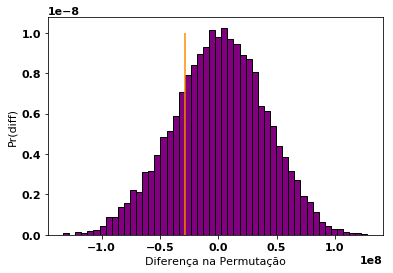

In [51]:
plt.hist(diferencas, bins=50, density=True, edgecolor='k', color="purple")
plt.xlabel('Diferença na Permutação')
plt.ylabel('Pr(diff)')
plt.vlines(val, 0, 1e-8, color='darkorange')
plt.show()

In [52]:
pvalor = 1 - percentileofscore(diferencas, val) / 100
print("O p-valor da permutação:", pvalor)

O p-valor da permutação: 0.7746999999999999


Com esse teste, temos um p-valor relativamente alto. Não podemos descartar a hipótese nula, de que a diferença entre os dois tipos de anos (eleitoral ou não) é devida ao acaso. Portanto, não podemos dizer se há de fato uma diferença entre as duas categorias.

<a id="classificacao"></a>
&nbsp;

___
# Classificação

Nesta seção, vamos tentar classificar os gastos por ministério, com base em quando ele foi efetuado e quanto foi gasto. 

Podemos criar uma nova coluna de tempo para substituir mês e ano. E, em seguida, normalizar:

In [53]:
# Leitura
df = dados.copy()
df["tempo"] = (df['ano']-2011)*12+df['mes']
df = df.drop('mes', 1)
df = df.drop('ano', 1)

TARGET = "nome_orgao_superior"
features = list(df.columns)
features.remove(TARGET)

# Normalização dos dados
df[features] = (df[features] - df[features].mean()) / df[features].std()
df.insert(0, 'intercepto', 1)
features.append('intercepto')

df.head()

,intercepto,nome_orgao_superior,gasto_total_mensal,tempo
0,1,GABINETE DA VICE-PRESIDENCIA DA REPUBLICA,-0.457709,-1.693300
1,1,GABINETE DA VICE-PRESIDENCIA DA REPUBLICA,-0.457695,-1.651978
2,1,GABINETE DA VICE-PRESIDENCIA DA REPUBLICA,-0.457707,-1.610656
3,1,GABINETE DA VICE-PRESIDENCIA DA REPUBLICA,-0.457699,-1.569333
4,1,GABINETE DA VICE-PRESIDENCIA DA REPUBLICA,-0.457661,-1.528011


Considere a seguinte função que separa treino e teste:

In [54]:
def separa(df):
    X = df[features].values
    y = df[TARGET].values
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        
    return X_train, y_train, X_test, y_test
  
X_train, y_train, X_test, y_test = separa(df)

<a id="knn"></a>
&nbsp;

### - KNN

Um método de classificação muito utilizado é o KNN, vamos ver o quão bem ele consegue vlassificar os nossos dados:

In [57]:
kf = KFold(n_splits=20, random_state=1, shuffle=False)

def knn(X_train, y_train):

    fold = 0
    melhores = []
    ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100]
    best_k = [0]*len(ks)

    for treino, validacao in kf.split(X_train, y_train):
        X_tt = X_train[treino]
        y_tt = y_train[treino]
        X_v = X_train[validacao]
        y_v = y_train[validacao]

        best = (0, 0)
        
        # Vamos testar tais valores de n
        for nn in ks:
            
            # Treina o modelo
            model = KNeighborsClassifier(n_neighbors=nn)
            model.fit(X_tt, y_tt)
            y_pv = model.predict(X_v)

            # Resultado com melhor acurácia!
            accuracy = accuracy_score(y_v, y_pv)
            if accuracy > best[0]:
                best = (accuracy, nn)

        melhores.append(best[1])
        fold += 1
        print('Fold-{}, melhor k = {}, acc = {}'.format(fold, best[1], best[0]))
    
        best_k[ks.index(best[1])] += 1 
    
    return ks[best_k.index(max(best_k))]
        
knn(X_train, y_train)

Fold-1, melhor k = 7, acc = 0.15476190476190477
Fold-2, melhor k = 8, acc = 0.17857142857142858
Fold-3, melhor k = 9, acc = 0.16666666666666666
Fold-4, melhor k = 6, acc = 0.16666666666666666
Fold-5, melhor k = 8, acc = 0.27380952380952384
Fold-6, melhor k = 9, acc = 0.17857142857142858
Fold-7, melhor k = 3, acc = 0.11904761904761904
Fold-8, melhor k = 10, acc = 0.19047619047619047
Fold-9, melhor k = 20, acc = 0.14285714285714285
Fold-10, melhor k = 9, acc = 0.17857142857142858
Fold-11, melhor k = 7, acc = 0.19047619047619047
Fold-12, melhor k = 8, acc = 0.17857142857142858
Fold-13, melhor k = 9, acc = 0.19047619047619047
Fold-14, melhor k = 50, acc = 0.15476190476190477
Fold-15, melhor k = 9, acc = 0.21428571428571427
Fold-16, melhor k = 6, acc = 0.1686746987951807
Fold-17, melhor k = 4, acc = 0.24096385542168675
Fold-18, melhor k = 10, acc = 0.14457831325301204
Fold-19, melhor k = 20, acc = 0.1686746987951807
Fold-20, melhor k = 9, acc = 0.1686746987951807


9

Podemos ver que a acurácia na validação cruzada ficou baixa, provavelmente devida a grande quantidade de classes (como vimos, são mais de 30 ministérios) e poucos features (estamos usando apenas a data e os gastos).

Para resolver isso, vamos verificar apenas com alguns dos ministérios mais importantes:

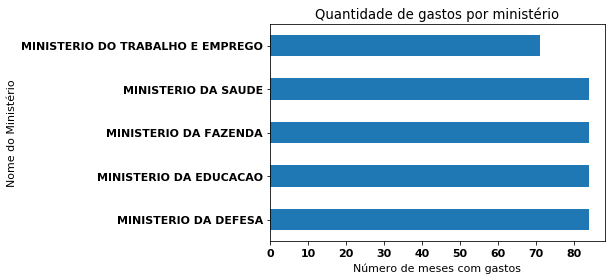

In [58]:
df_importantes = df[df.nome_orgao_superior.isin(
    ["MINISTERIO DA EDUCACAO", "MINISTERIO DA FAZENDA", "MINISTERIO DA SAUDE",
     "MINISTERIO DA DEFESA", "MINISTERIO DO TRABALHO E EMPREGO"])]

df2 = df_importantes.groupby(TARGET).size()
df2.plot(title='Quantidade de gastos por ministério', kind='barh')
plt.ylabel("Nome do Ministério")
plt.xlabel("Número de meses com gastos")
plt.show()

Agora, usando o KNN sobre esses dados:

In [62]:
X_train2, y_train2, X_test2, y_test2 = separa(df_importantes)
melhor_k = knn(X_train2, y_train2)

Fold-1, melhor k = 40, acc = 0.6470588235294118
Fold-2, melhor k = 2, acc = 0.7647058823529411
Fold-3, melhor k = 7, acc = 0.8823529411764706
Fold-4, melhor k = 2, acc = 0.8235294117647058
Fold-5, melhor k = 20, acc = 0.6470588235294118
Fold-6, melhor k = 100, acc = 0.6875
Fold-7, melhor k = 5, acc = 0.625
Fold-8, melhor k = 7, acc = 0.75
Fold-9, melhor k = 5, acc = 0.8125
Fold-10, melhor k = 7, acc = 0.6875
Fold-11, melhor k = 7, acc = 0.6875
Fold-12, melhor k = 20, acc = 0.625
Fold-13, melhor k = 3, acc = 0.6875
Fold-14, melhor k = 2, acc = 0.625
Fold-15, melhor k = 5, acc = 0.625
Fold-16, melhor k = 3, acc = 0.6875
Fold-17, melhor k = 4, acc = 0.5
Fold-18, melhor k = 10, acc = 0.5
Fold-19, melhor k = 2, acc = 0.625
Fold-20, melhor k = 40, acc = 0.5


Observamos que a acurácia na validação cruzada ficou bem melhor. Vamos agora olhar a qualidade da nossa classificação no teste:

                                  precision    recall  f1-score   support

            MINISTERIO DA DEFESA       0.52      0.72      0.60        18
          MINISTERIO DA EDUCACAO       0.59      0.53      0.56        19
           MINISTERIO DA FAZENDA       0.33      0.24      0.28        21
             MINISTERIO DA SAUDE       0.22      0.22      0.22         9
MINISTERIO DO TRABALHO E EMPREGO       0.81      0.87      0.84        15

                     avg / total       0.51      0.52      0.51        82

Acurácia: 0.524390243902439


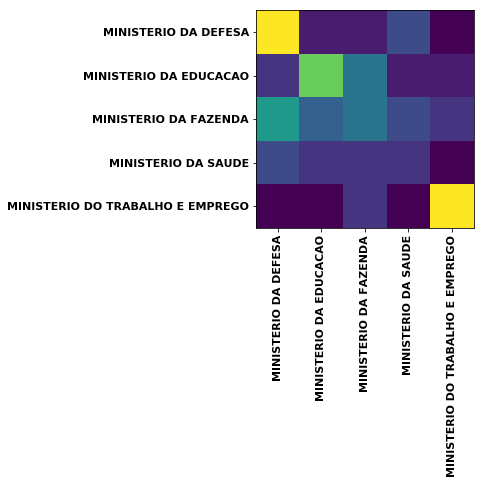

In [63]:
model = KNeighborsClassifier(n_neighbors=melhor_k)
model.fit(X_train2, y_train2)

# Precisão, recall, f1, suporte
pred = model.predict(X_test2)
print(classification_report(y_test2, pred))
print("Acurácia:", sum(y_test2==pred)/len(pred))

# Matriz de confusão
text_labels = list(set(list(df_importantes['nome_orgao_superior'])))
index = np.arange(len(text_labels))
labels = pd.Series(text_labels, index=index)

plt.imshow(confusion_matrix(y_test2, model.predict(X_test2)))
plt.xticks(labels.index, labels, rotation=90)
plt.yticks(labels.index, labels)
plt.show()

No caso de poucos órgãos, a classificação consegue ser boa. Tendo em vista que estamos usando apenas os gastos e suas datas, é um resultado muito bom.

<a id="logis"></a>
&nbsp;

### - Regressão Logística Regularizada

Podemos comparar os resultados acima com outro método de classificação muito utilizado, a regressão logística. Vejamos:

In [64]:
model = LogisticRegressionCV(Cs=100, fit_intercept=False, multi_class='ovr')
model.fit(X_train, y_train)

pred = model.predict(X_test)
print(classification_report(y_test, pred))
print("Acurácia:", sum(y_test==pred)/len(pred))

/Users/luizagaluppo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


                                               precision    recall  f1-score   support

    GABINETE DA VICE-PRESIDENCIA DA REPUBLICA       1.00      0.50      0.67         2
 MINIST. DA AGRICUL.,PECUARIA E ABASTECIMENTO       0.00      0.00      0.00        18
MINIST. DA INDUSTRIA, COM.EXTERIOR E SERVICOS       0.00      0.00      0.00         2
 MINIST. DO PLANEJAMENTO, DESENVOLV. E GESTAO       0.00      0.00      0.00         6
MINIST.DA CIENCIA,TECNOL.,INOV.E COMUNICACOES       0.00      0.00      0.00         7
    MINIST.DOS TRANSP.,PORTOS E AVIACAO CIVIL       0.00      0.00      0.00         3
           MINISTERIO DA CIENCIA E TECNOLOGIA       0.00      0.00      0.00         6
 MINISTERIO DA CIENCIA, TECNOLOGIA E INOVACAO       0.00      0.00      0.00        13
                        MINISTERIO DA CULTURA       0.00      0.00      0.00        15
                         MINISTERIO DA DEFESA       0.00      0.00      0.00        15
                       MINISTERIO DA EDUCA

/Users/luizagaluppo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luizagaluppo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Mais uma vez, vemos que o resultado foi muito ruim. Vamos, então, usar novamente o conjunto reduzido dos dados, apenas com 5 classes.

                                  precision    recall  f1-score   support

            MINISTERIO DA DEFESA       0.33      0.06      0.10        18
          MINISTERIO DA EDUCACAO       0.34      0.95      0.50        19
           MINISTERIO DA FAZENDA       0.00      0.00      0.00        21
             MINISTERIO DA SAUDE       0.09      0.22      0.12         9
MINISTERIO DO TRABALHO E EMPREGO       1.00      0.20      0.33        15

                     avg / total       0.34      0.29      0.21        82

Acurácia: 0.2926829268292683


/Users/luizagaluppo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


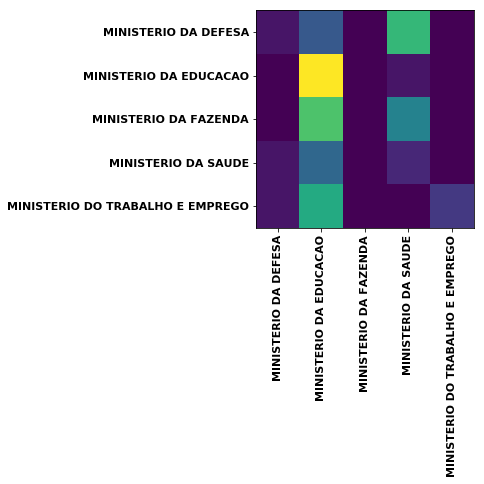

In [65]:
model.fit(X_train2, y_train2)
pred2 = model.predict(X_test2)
print(classification_report(y_test2, pred2))
print("Acurácia:", sum(y_test2==pred2)/len(pred2))


index = np.arange(len(text_labels))
labels = pd.Series(text_labels, index=index)

plt.imshow(confusion_matrix(y_test2, model.predict(X_test2)))
plt.xticks(labels.index, labels, rotation=90)
plt.yticks(labels.index, labels)
plt.show()

Observamos que a acurácia da regressão foi muito pior que do kNN. A regressão demonstra não ter resultados bons quando há várias classes. Ao reduzir o número de classes, ambos os algoritmos se comportaram muito melhor.

Nas vezes que rodamos, a regressão terminou com acurácia entre 0.20 e 0.30, ou seja, apenas um pouco melhor que sortear a resposta. Já o kNN terminou com acurácia de até 0.7, o que é surpreendente, pois os dados não são tantos, e há apenas duas features.

<a id="regressao"></a>
&nbsp;

___
# Regressão

Nesta seção, compararemos o desempenho do kNN e de uma Regressão Linear Regularizada para descrever os gastos diretos totais ao longo do tempo e de alguns ministérios.

In [66]:
dados_reg = dados.copy()
dados_reg["tempo"] = (dados_reg['ano']-2011)*12+dados_reg['mes']
dados_reg.head()
novo = pd.DataFrame(dados_reg[["gasto_total_mensal", "tempo"]].values, index=dados_reg['nome_orgao_superior'])
novo = (novo - novo.mean()) / novo.std()
novo.insert(0, 'intercepto', 1)

novo.head()

,intercepto,0,1
nome_orgao_superior,,,
GABINETE DA VICE-PRESIDENCIA DA REPUBLICA,1,-0.457709,-1.693300
GABINETE DA VICE-PRESIDENCIA DA REPUBLICA,1,-0.457695,-1.651978
GABINETE DA VICE-PRESIDENCIA DA REPUBLICA,1,-0.457707,-1.610656
GABINETE DA VICE-PRESIDENCIA DA REPUBLICA,1,-0.457699,-1.569333
GABINETE DA VICE-PRESIDENCIA DA REPUBLICA,1,-0.457661,-1.528011


Veremos o erro quadrático médio que obtemos ao fazer algumas regressões. Para isso, usaremos as seguintes funções:

In [67]:
def resultado(y_true, y_prev, orgao=""):
    mse = np.round(((y_true - y_prev) ** 2).mean(), 3)
    print(orgao, "MSE: {}".format(mse))

In [68]:
def plot_reg(X_test, y_test, t, pred):
    plt.scatter(X_test[:,1], y_test, c='k', label='data')
    plt.plot(t, pred, c='g', label='prediction')
    plt.ylabel("Gasto (normalizado)")
    plt.xlabel("Tempo (normalizado)")
    plt.axis('tight')
    plt.legend()
    plt.title("Regressão - " + orgao)
    plt.show()

<a id="regressao_knn"></a>
&nbsp;

### - Regressão KNN

Considere o modelo de regressão KNN abaixo

In [69]:
def regressao_knn(X_train, y_train, X_test):
    parameters = [{'weights': ['uniform', 'distance'], 'n_neighbors': range(2,32)}]
    reg = GridSearchCV(KNeighborsRegressor(), parameters, cv=5, scoring='neg_mean_squared_error')
    reg.fit(X_train, y_train)
    print("k =", reg.best_estimator_.n_neighbors)
    
    t = pd.DataFrame(np.arange(X_test[:,1].min(), X_test[:,1].max(), 0.01))
    t.insert(0, 'intercepto', 1)
    t = t.values
    
    return reg.predict(X_test), t[:,1], reg.predict(t)

Vejamos o resultado:

k = 29
Gastos Totais MSE: 0.868


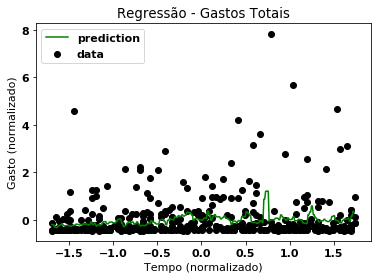

k = 10
MINISTERIO DA EDUCACAO MSE: 1.044


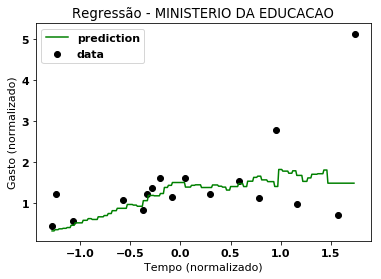

k = 31
MINISTERIO DA FAZENDA MSE: 1.919


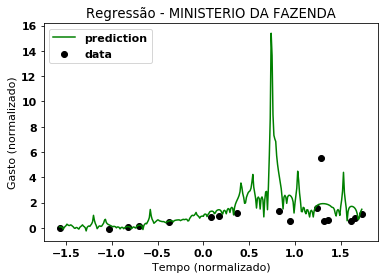

k = 16
MINISTERIO DA SAUDE MSE: 0.024


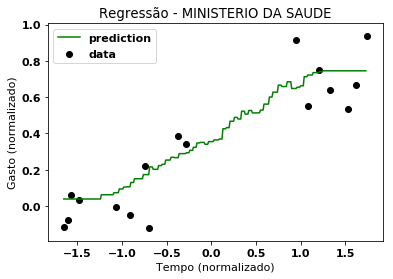

k = 19
MINISTERIO DA DEFESA MSE: 0.091


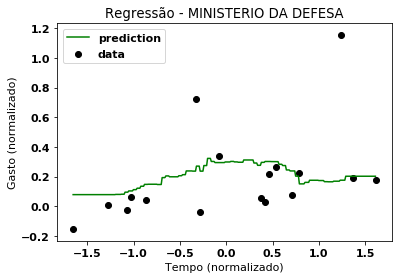

k = 3
MINISTERIO DO TRABALHO E EMPREGO MSE: 1.419


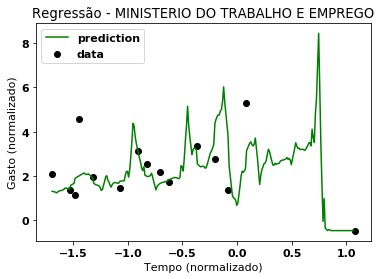

In [70]:
# Gastos Totais
orgao = "Gastos Totais"
X = novo[["intercepto", 1]].values
y = novo[0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
pred_knn, t, pred_t = regressao_knn(X_train, y_train, X_test)
resultado(y_test, pred_knn, orgao)
plot_reg(X_test, y_test, t, pred_t)

# Gastos por ministérios
lista_orgaos = ["MINISTERIO DA EDUCACAO", "MINISTERIO DA FAZENDA", "MINISTERIO DA SAUDE",
                "MINISTERIO DA DEFESA", "MINISTERIO DO TRABALHO E EMPREGO"]

for orgao in lista_orgaos:
    dados_orgao = novo.loc[[orgao]]

    X = dados_orgao[["intercepto", 1]].values
    y = dados_orgao[0].values
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    pred_knn, t, pred_t = regressao_knn(X_train, y_train, X_test)
    resultado(y_test, pred_knn, orgao)
    plot_reg(X_test, y_test, t, pred_t)

Vemos que o MSE acaba sendo pequeno, talvez apenas não seja o caso do Ministério da Fazenda devido ao pico que discutimos.

<a id="regul"></a>
&nbsp;

### - Regressão linear regularizada

Considere o seguinte modelo de regressão linear

In [71]:
def regressao_linear(X_train, y_train, X_test):
    parameters = [{'alpha': [25,10,4,2,1.0]}]
    reg = GridSearchCV(Ridge(fit_intercept=False), parameters, cv=5, scoring='neg_mean_squared_error')
    reg.fit(X_train, y_train)
    
    t = pd.DataFrame(np.arange(X_test[:,1].min(), X_test[:,1].max(), 0.01))
    t.insert(0, 'intercepto', 1)
    t = t.values
        
    return reg.predict(X_test), t[:,1], reg.predict(t)


Vejamos o resultado:

Gastos Totais MSE: 0.831


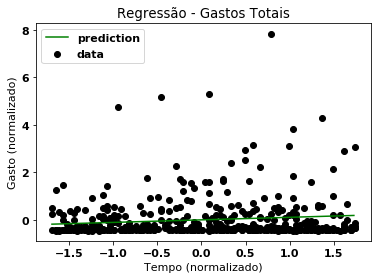

MINISTERIO DA EDUCACAO MSE: 0.315


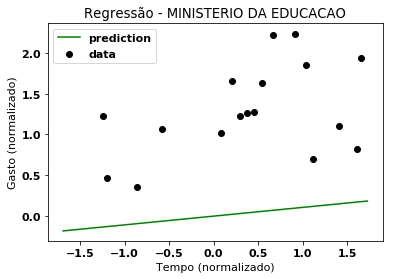

MINISTERIO DA FAZENDA MSE: 0.509


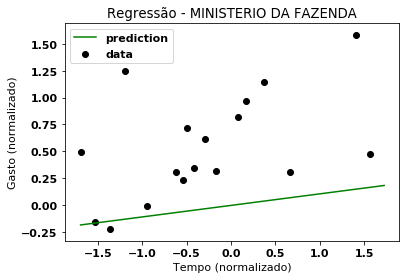

MINISTERIO DA SAUDE MSE: 0.041


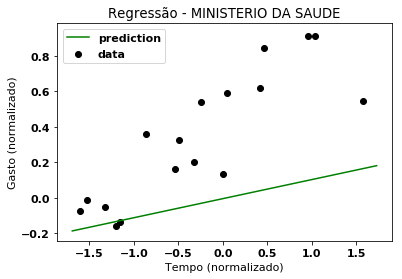

MINISTERIO DA DEFESA MSE: 0.066


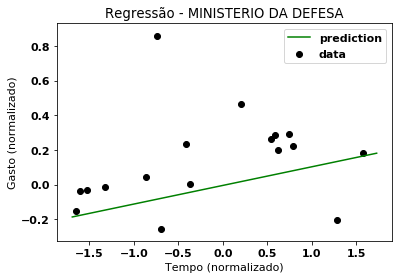

MINISTERIO DO TRABALHO E EMPREGO MSE: 2.947


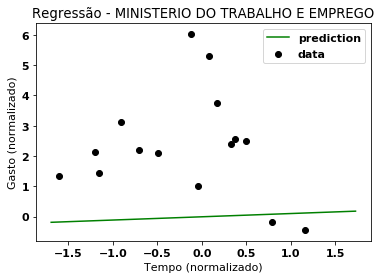

In [72]:
# Gastos Totais
orgao = "Gastos Totais"
X = novo[["intercepto", 1]].values
y = novo[0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
pred_lin, t, pred_t = regressao_linear(X_train, y_train, X_test)
resultado(y_test, pred_lin, orgao)
plot_reg(X_test, y_test, t, pred_t)

# Gastos por ministérios
lista_orgaos = ["MINISTERIO DA EDUCACAO", "MINISTERIO DA FAZENDA", "MINISTERIO DA SAUDE",
                "MINISTERIO DA DEFESA", "MINISTERIO DO TRABALHO E EMPREGO"]

for orgao in lista_orgaos:
    dados_orgao = novo.loc[[orgao]]

    X = dados_orgao[["intercepto", 1]].values
    y = dados_orgao[0].values
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    pred_lin = regressao_linear(X_train, y_train, X_test)[0]
    resultado(y_test, pred_lin, orgao)
    plot_reg(X_test, y_test, t, pred_t)

Os valores do MSE foram similares aos do KNN, e em alguns gráficos vemos uma relação linear.

Gastos de alguns ministérios mais conhecidos

**Ministério da Educação**: É possível perceber um leve aumento nos gastos. E que em alguns dos meses finais ocorreram gastos com um valor consideravelmente mais alto que os outros.

**Ministério da Fazenda**: A regressão nos mostra um aumento considerável, porém no final é possível ver uma queda considerável nos valores.

**Ministério da Saúde**: Também com um aumento considerável nos gastos, e a maior parte dos pontos seguem bem a regressão linear.

**Ministério da Defesa**: Apresenta um aumento leve, porém possui gastos bem dispersos.

**Ministério do Trabalho e do Emprego**: A regressão mostra uma leve queda nos gastos, porém nos últimos meses é percepitível gastos com valores bem inferiores do resto.


<a id="conclusoes"></a>
&nbsp;

___
# Conclusões

Por fim, façamos uma análise de nossas perguntas:

1. Não conseguimos mostrar que os gastos não são uniformemente distribuídos ao longo do ano.
1. Não conseguimos mostrar que os anos eleitorais possuem gastos diferentes dos demais anos.
1. Conseguimos classificar razoavelmente bem os ministérios apenas pelos gastos e datas.
1. As regressões capturaram parte do comportamento dos gastos.